## Modeling Notebook

In [2]:
# General Packages
import pandas as pd
import yfinance as yf
import numpy as np
import seaborn as sns
from yahooquery import Ticker
from tqdm import tqdm
import matplotlib.pyplot as plt

# SK-Learn Packages
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer, mean_squared_error
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression

# CNN Modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical
from keras.metrics import Precision, Recall, AUC
from keras import backend as K

In [3]:
# Reading in most recent data
stock_data = pd.read_csv('data/CompletedData.csv')
stock_data.drop(['Unnamed: 0'], axis = 1, inplace = True)
stock_data.dropna(inplace = True)
stock_data.head()

,Ticker,AveragePriceTarget,NumRatings,ClosingPrice,MarketCap,ExpectedGrowthRate,OverallRecommendation,ProjectedMarketCap,TotalRevenue,NormEBITDA,ReturnOnAssets,ChangeNormEBITDA,ChangeRevenue,OperatingCashFlow,ChangeOCF,Sector
0,A,166.5,14,138.09,4.088458e+10,0.206,1,4.930681e+10,6.848000e+09,1.985000e+09,0.10102,80000000.0,529000000.0,1.353000e+09,41000000.0,Healthcare
1,AA,50.0,11,39.43,7.032538e+09,0.268,1,8.917258e+09,1.245100e+10,2.142000e+09,0.05931,-231000000.0,299000000.0,8.220000e+08,0.0,Basic Materials
2,AAN,16.0,5,9.54,2.936460e+08,0.677,1,4.924443e+08,2.249434e+09,7.345500e+08,0.06360,0.0,403930000.0,1.704320e+08,0.0,Industrials
3,AAOI,3.4,4,2.11,6.130162e+07,0.611,1,9.875690e+07,2.228180e+08,-3.543400e+07,-0.08548,24643000.0,11253000.0,-1.402200e+07,0.0,Technology
4,AAP,155.0,17,120.21,7.122887e+09,0.289,1,9.181402e+09,1.115472e+10,9.909550e+08,0.03891,0.0,156733000.0,7.222220e+08,0.0,Consumer Cyclical


In [10]:
stock_data.describe()

,AveragePriceTarget,NumRatings,ClosingPrice,MarketCap,ExpectedGrowthRate,OverallRecommendation,ProjectedMarketCap,TotalRevenue,NormEBITDA,ReturnOnAssets,ChangeNormEBITDA,ChangeRevenue,OperatingCashFlow,ChangeOCF
count,1945.000000,1945.000000,1945.000000,1.945000e+03,1945.000000,1945.000000,1.945000e+03,1.945000e+03,1.945000e+03,1945.000000,1.945000e+03,1.945000e+03,1.945000e+03,1.945000e+03
mean,74.216329,9.573265,62.437311,9.412715e+09,0.392974,0.788175,1.099520e+10,4.109402e+09,7.962129e+08,-0.020698,3.504065e+07,4.854726e+08,5.613016e+08,2.675059e+06
std,140.557936,4.691940,128.272359,1.850647e+10,0.413331,0.408707,2.066704e+10,7.251109e+09,1.481109e+09,0.182612,1.406330e+08,1.030938e+09,1.067708e+09,1.025702e+08
min,0.600000,4.000000,0.390000,2.959104e+07,-0.151000,0.000000,4.259801e+07,0.000000e+00,-9.360000e+08,-1.000000,-4.180000e+08,-1.514000e+09,-5.137450e+08,-1.710000e+09
25%,15.500000,6.000000,10.730000,9.377692e+08,0.121000,1.000000,1.405625e+09,3.480850e+08,-1.026871e+07,-0.043340,0.000000e+00,1.528700e+07,-8.415000e+06,0.000000e+00
50%,36.580000,8.000000,28.310000,2.818498e+09,0.256000,1.000000,3.642117e+09,1.356660e+09,2.406280e+08,0.027930,0.000000e+00,1.302310e+08,1.683100e+08,0.000000e+00
75%,85.000000,13.000000,71.190000,8.396930e+09,0.510000,1.000000,1.015952e+10,4.581100e+09,9.306570e+08,0.065240,9.199000e+06,5.360000e+08,6.257270e+08,0.000000e+00
max,2800.000000,20.000000,2615.600000,1.972006e+11,1.991000,1.000000,2.271751e+11,1.091200e+11,1.257500e+10,0.238460,1.309928e+09,8.335000e+09,7.762000e+09,2.518713e+09


In [5]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2135 entries, 0 to 2135
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Ticker                 2135 non-null   object 
 1   AveragePriceTarget     2135 non-null   float64
 2   NumRatings             2135 non-null   int64  
 3   ClosingPrice           2135 non-null   float64
 4   MarketCap              2135 non-null   float64
 5   ExpectedGrowthRate     2135 non-null   float64
 6   OverallRecommendation  2135 non-null   int64  
 7   ProjectedMarketCap     2135 non-null   float64
 8   TotalRevenue           2135 non-null   float64
 9   NormEBITDA             2135 non-null   float64
 10  ReturnOnAssets         2135 non-null   float64
 11  ChangeNormEBITDA       2135 non-null   float64
 12  ChangeRevenue          2135 non-null   float64
 13  OperatingCashFlow      2135 non-null   float64
 14  ChangeOCF              2135 non-null   float64
 15  Sect

We're now ready to set up our first model

### Random Forest Classifier

In [295]:
modeling_df = stock_data[['Ticker', 'TotalRevenue', 'NormEBITDA', 'ReturnOnAssets','ChangeNormEBITDA','ChangeRevenue','OperatingCashFlow','ChangeOCF','OverallRecommendation']]
modeling_df.set_index('Ticker', inplace = True)

In [296]:
X = modeling_df.drop(['OverallRecommendation'], axis = 1)
y = modeling_df['OverallRecommendation']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

In [306]:
# Smote to address class imbalance
smt = SMOTE(random_state = 42)
# Scaling Data
ss = StandardScaler()
# Principal Component Analysis to address Multicolinearity
pca = PCA(n_components = 7)
# Instantiate Model, Pipeline
rfc = RandomForestClassifier(random_state = 42)
rfc_pipeline = Pipeline([('smote', smt),('scaler', ss),('pca', pca), ('random_forest', rfc)])

0.8048780487804877


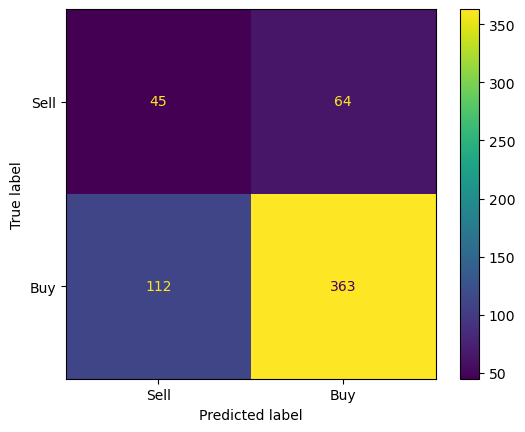

In [314]:
rfc_pipeline.fit(X_train, y_train)
y_pred = rfc_pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f1)
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
ConfusionMatrixDisplay(cm, display_labels= ['Sell','Buy']).plot()

Hyper Parameter Tuning

In [308]:
rfc_params = {'random_forest__max_depth': [5,10,15,20,25], 'random_forest__n_estimators': [45,50,55,60,65]}

In [309]:
gs = GridSearchCV(rfc_pipeline, rfc_params, cv = 5, scoring = 'f1', verbose = 1)
gs.fit(X_train,y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=7)),
                                       ('random_forest',
                                        RandomForestClassifier(random_state=42))]),
             param_grid={'random_forest__max_depth': [5, 10, 15, 20, 25],
                         'random_forest__n_estimators': [45, 50, 55, 60, 65]},
             scoring='f1', verbose=1)

In [310]:
gs.best_params_

{'random_forest__max_depth': 20, 'random_forest__n_estimators': 55}

In [311]:
gs.best_score_

0.7655829371001845

Updating Parameters

In [312]:
rfc = RandomForestClassifier(max_depth = 20, n_estimators = 55, random_state = 42)
rfc_pipeline = Pipeline([('smote', smt),('scaler', ss),('random_forest', rfc)])

0.7178026924980342


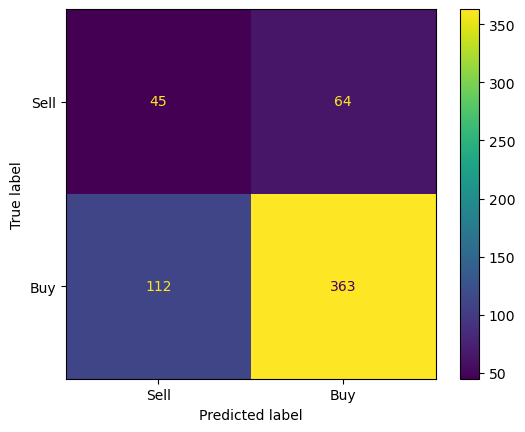

In [313]:
rfc_pipeline.fit(X_train, y_train)
y_pred = rfc_pipeline.predict(X_test)
f1 = f1_score(y_test, y_pred, average = 'weighted')
print(f1)
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
ConfusionMatrixDisplay(cm, display_labels= ['Sell','Buy']).plot()

### Convolutional Neural Network

Preprocessing Data

In [315]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 42)

In [316]:
# Preparing Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE
smt = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smt.fit_resample(X_train, y_train)

# PCA
pca = PCA(n_components = 5)
X_train_ready = pca.fit_transform(X_train_resampled)
X_test_ready = pca.transform(X_test_scaled)

# Reshaping Data
X_train_ready = X_train_resampled.values.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1], 1)
X_test_ready = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

# Map labels to non-negative integers
# Encode labels
y_train_encoded = to_categorical(y_train_resampled)
y_test_encoded = to_categorical(y_test)

c:\Users\cnade\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


In [317]:
X_test_ready.shape

(584, 7, 1)

In [318]:
y_train_encoded.shape

(2116, 2)

In [319]:
# Creating F1 Score
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [320]:
# Creating Neural Network Function
def create_classification_model(dropout_rate=0.2, l2_weight=0.001, batch_size=32, epochs=10):
    model = Sequential()
    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_ready.shape[1],1), kernel_regularizer=l2(l2_weight)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_weight)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(2, activation='softmax', kernel_regularizer=l2(l2_weight)))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1_m])
    return model

In [324]:
model = create_classification_model()
model.fit(X_train_ready, y_train_encoded, epochs=25, validation_data=(X_test_ready, y_test_encoded))

Epoch 1/25
19/19 [==============================] - 3s 30ms/step - loss: 0.7471 - f1_m: 0.7566 - val_loss: 0.6526 - val_f1_m: 0.8207
Epoch 2/25
19/19 [==============================] - 0s 11ms/step - loss: 0.6299 - f1_m: 0.8109 - val_loss: 0.6008 - val_f1_m: 0.8207
Epoch 3/25
19/19 [==============================] - 0s 11ms/step - loss: 0.5949 - f1_m: 0.8010 - val_loss: 0.5777 - val_f1_m: 0.8207
Epoch 4/25
19/19 [==============================] - 0s 10ms/step - loss: 0.5755 - f1_m: 0.8158 - val_loss: 0.5624 - val_f1_m: 0.8207
Epoch 5/25
19/19 [==============================] - 0s 11ms/step - loss: 0.5589 - f1_m: 0.8191 - val_loss: 0.5473 - val_f1_m: 0.8224
Epoch 6/25
19/19 [==============================] - 0s 11ms/step - loss: 0.5564 - f1_m: 0.8158 - val_loss: 0.5366 - val_f1_m: 0.8207
Epoch 7/25
19/19 [==============================] - 0s 11ms/step - loss: 0.5448 - f1_m: 0.8224 - val_loss: 0.5277 - val_f1_m: 0.8240
Epoch 8/25
19/19 [==============================] - 0s 11ms/step - lo

## Modeling for Expected Growth Rate

In [4]:
modeling_growth_df = stock_data[['Ticker', 'TotalRevenue', 'NormEBITDA', 'ReturnOnAssets','ChangeNormEBITDA','ChangeRevenue','OperatingCashFlow','ChangeOCF', 'ExpectedGrowthRate', 'Sector']]
modeling_growth_df.set_index('Ticker', inplace = True)

In [5]:
X = modeling_growth_df.drop(['ExpectedGrowthRate', 'Sector'], axis = 1)
y = modeling_growth_df['ExpectedGrowthRate']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 42)

#### Linear Regression Baseline Model

In [8]:
linreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Fit pipeline to training data
linreg_pipeline.fit(X_train, y_train)

# Evaluate pipeline on testing data
y_pred = linreg_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Root mean squared error:', rmse)

Root mean squared error: 0.4021873021021452


In [17]:
y_pred_mapped = np.where(y_pred < 0.1, 0, 1)
y_test_mapped = np.where(y_test < 0.1, 0, 1)

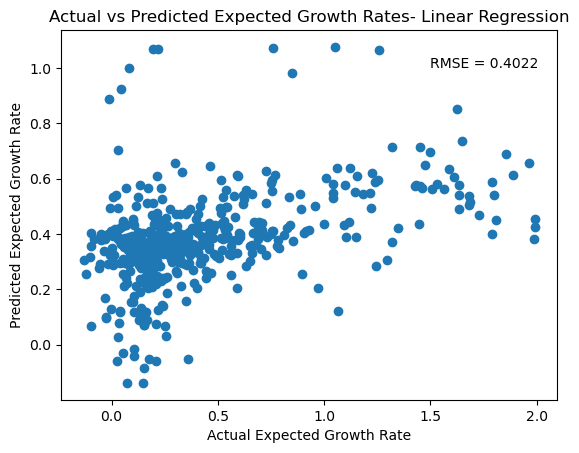

In [9]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Expected Growth Rate')
plt.ylabel('Predicted Expected Growth Rate')
plt.title('Actual vs Predicted Expected Growth Rates- Linear Regression')
plt.text(1.5,1, 'RMSE = 0.4022')
plt.show()

### Neural Network P2- A Feedforward Neural Network

In [10]:
# Preparing Data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshaping Data
X_train_ready = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_ready = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

In [11]:
def create_continuous_model(dropout_rate=0.2, l2_weight=0.001, batch_size=32, epochs=10):
    model = Sequential()
#    model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train_ready.shape[1],1), kernel_regularizer=l2(l2_weight)))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(l2_weight)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='linear', kernel_regularizer=l2(l2_weight)))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])
    return model

In [37]:
model = create_continuous_model()
model.fit(X_train_ready, y_train, epochs = 25, batch_size = 32, validation_data=[X_test_ready, y_test])

Epoch 1/25
46/46 [==============================] - 2s 11ms/step - loss: 0.2258 - mse: 0.2106 - val_loss: 0.1724 - val_mse: 0.1575
Epoch 2/25
46/46 [==============================] - 0s 6ms/step - loss: 0.1806 - mse: 0.1659 - val_loss: 0.1637 - val_mse: 0.1493
Epoch 3/25
46/46 [==============================] - 0s 6ms/step - loss: 0.1676 - mse: 0.1534 - val_loss: 0.1620 - val_mse: 0.1480
Epoch 4/25
46/46 [==============================] - 0s 5ms/step - loss: 0.1653 - mse: 0.1517 - val_loss: 0.1531 - val_mse: 0.1397
Epoch 5/25
46/46 [==============================] - 0s 6ms/step - loss: 0.1662 - mse: 0.1531 - val_loss: 0.1507 - val_mse: 0.1378
Epoch 6/25
46/46 [==============================] - 0s 5ms/step - loss: 0.1507 - mse: 0.1380 - val_loss: 0.1493 - val_mse: 0.1368
Epoch 7/25
46/46 [==============================] - 0s 5ms/step - loss: 0.1480 - mse: 0.1357 - val_loss: 0.1509 - val_mse: 0.1388
Epoch 8/25
46/46 [==============================] - 0s 6ms/step - loss: 0.1476 - mse: 0.1

In [38]:
y_pred = model.predict(X_test_ready)

16/16 [==============================] - 0s 2ms/step


In [39]:
y_pred = pd.Series(y_pred.flatten())

In [40]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print('Root mean squared error:', rmse)

Root mean squared error: 0.3675623037070377


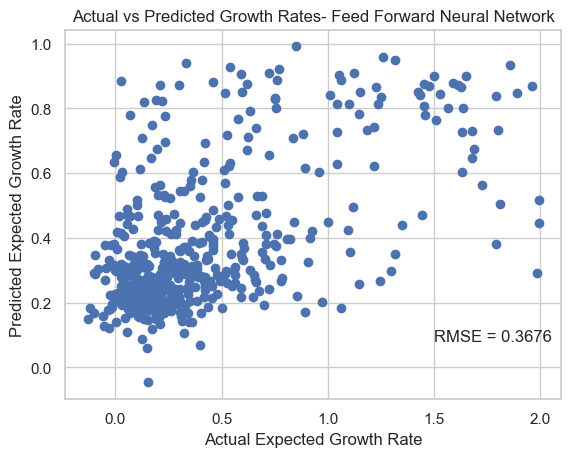

In [42]:
plt.scatter(y_test, y_pred)
plt.xlabel('Actual Expected Growth Rate')
plt.ylabel('Predicted Expected Growth Rate')
plt.title('Actual vs Predicted Growth Rates- Feed Forward Neural Network')
#plt.legend(['RMSE: {:.4f}'.format(mse)])
plt.text(1.5,0.08, 'RMSE = 0.3676')
plt.show()

#### Breaking Down Sector Performance

In [22]:
y_pred.name = 'ProjectedGrowthRate'
y_pred.index = y_test.index

In [23]:
sector_series = modeling_growth_df['Sector']
sector_series

Ticker
A               Healthcare
AA         Basic Materials
AAN            Industrials
AAOI            Technology
AAP      Consumer Cyclical
               ...        
ZS              Technology
ZTS             Healthcare
ZVIA    Consumer Defensive
ZWS            Industrials
ZYXI            Healthcare
Name: Sector, Length: 1945, dtype: object

In [24]:
Merged_Predictions = pd.concat([y_test, y_pred], axis=1)

Merged_Predictions_With_Sector = Merged_Predictions.join(sector_series, how = 'inner')

In [25]:
Merged_Predictions_With_Sector

,ExpectedGrowthRate,ProjectedGrowthRate,Sector
Ticker,,,
SPGI,0.164,0.122456,Financial Services
PRVB,0.029,0.809790,Healthcare
KEYS,0.212,0.158705,Technology
LTHM,0.480,0.248114,Basic Materials
CAKE,0.098,0.289121,Consumer Cyclical
...,...,...,...
MANH,0.080,0.256197,Technology
PANW,0.184,0.293648,Technology
CDNA,0.515,0.544227,Healthcare


Calculating Residuals

In [26]:
Merged_Predictions_With_Sector['Residual Magnitude'] = np.absolute((Merged_Predictions_With_Sector['ExpectedGrowthRate'] - Merged_Predictions_With_Sector['ProjectedGrowthRate']))

Grouping by Sector, finding mean

In [35]:
averages_by_sector = Merged_Predictions_With_Sector.groupby('Sector')['Residual Magnitude'].mean().reset_index()
averages_by_sector

,Sector,Residual Magnitude
0,Basic Materials,0.160588
1,Communication Services,0.380602
2,Consumer Cyclical,0.178745
3,Consumer Defensive,0.198039
4,Energy,0.183484
5,Financial Services,0.163208
6,Healthcare,0.410051
7,Industrials,0.172552
8,Real Estate,0.133369
9,Technology,0.294108


In [36]:
# Sector Counts in Test Data
Merged_Predictions_With_Sector['Sector'].value_counts()

Healthcare                105
Technology                 89
Consumer Cyclical          72
Industrials                67
Real Estate                32
Consumer Defensive         30
Basic Materials            26
Communication Services     20
Energy                     19
Utilities                  15
Financial Services         12
Name: Sector, dtype: int64

Looks like our model is predicting Real Estate really well, while not doing as well with Healthcare and Communication Services companies performing the worst

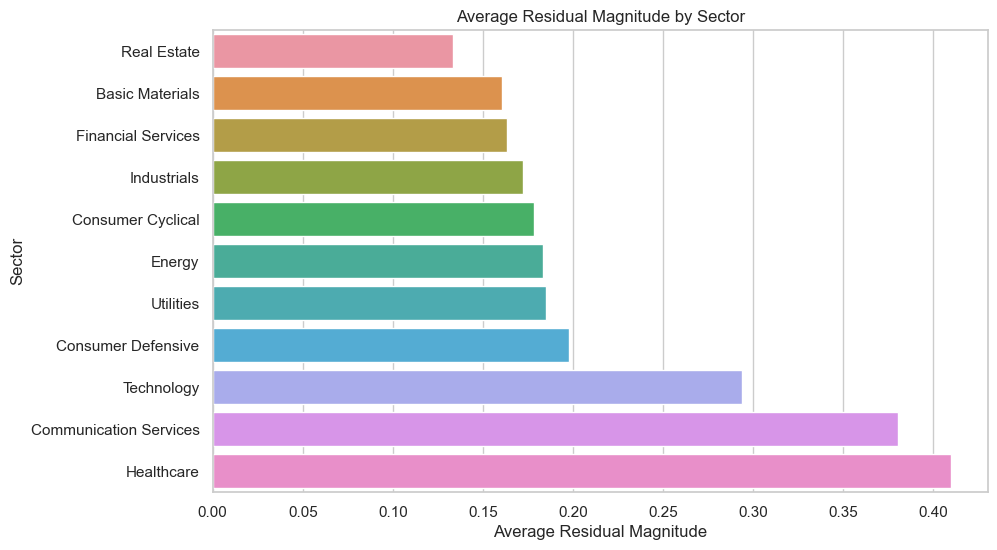

In [28]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x='Residual Magnitude', y='Sector', data=averages_by_sector.sort_values('Residual Magnitude', ascending=True))
plt.title('Average Residual Magnitude by Sector')
plt.xlabel('Average Residual Magnitude')
plt.ylabel('Sector')
plt.show()